# Appendix
Code File:

In [1]:
#imports 
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

### Reading the CSV and balancing the data

In [2]:
data = pd.read_csv("bee_data.csv")
data.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [3]:
data.subspecies.value_counts()

Italian honey bee        3008
Russian honey bee         527
Carniolan honey bee       501
1 Mixed local stock 2     472
-1                        428
VSH Italian honey bee     199
Western honey bee          37
Name: subspecies, dtype: int64

In [4]:
data = data.drop(['date', 'time', 'location', 'zip code', 'subspecies', 'pollen_carrying', 'caste'], axis=1)
data.head()

,file,health
0,041_066.png,hive being robbed
1,041_072.png,hive being robbed
2,041_073.png,hive being robbed
3,041_067.png,hive being robbed
4,041_059.png,hive being robbed


In [5]:
data.health.value_counts()

healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64

In [6]:
#0 is unhealthy
#1 is healthy
data['health_categorical'] = np.where(data['health']!= 'healthy', 0, 1)
data.head()

,file,health,health_categorical
0,041_066.png,hive being robbed,0
1,041_072.png,hive being robbed,0
2,041_073.png,hive being robbed,0
3,041_067.png,hive being robbed,0
4,041_059.png,hive being robbed,0


In [7]:
a = data.health_categorical.value_counts()
print(a)
print("0 values : " + str(a[0]))

1    3384
0    1788
Name: health_categorical, dtype: int64
0 values : 1788


In [8]:
# Need to make the dataset balanced for 0 and 1 entries
data_1 = data[data['health_categorical'] == 1]
data_1.health_categorical.value_counts()

1    3384
Name: health_categorical, dtype: int64

In [9]:
data_1_sampled = data_1.sample(n = a[0])
len(data_1_sampled)

1788

In [10]:
data_final = pd.concat([data_1_sampled, data[data['health_categorical'] == 0]])
data_final.head()

,file,health,health_categorical
1269,005_301.png,healthy,1
4029,032_549.png,healthy,1
2918,010_595.png,healthy,1
3100,018_050.png,healthy,1
3608,015_1116.png,healthy,1


In [11]:
print(data_final.health_categorical.value_counts())
print("\nDataset Size:" + str(len(data_final)))

1    1788
0    1788
Name: health_categorical, dtype: int64

Dataset Size:3576


In [12]:
data_final = data_final.drop(['health'], axis=1)
data_final.head()

,file,health_categorical
1269,005_301.png,1
4029,032_549.png,1
2918,010_595.png,1
3100,018_050.png,1
3608,015_1116.png,1


In [13]:
#Randomizing the dataset for the train/test split
data_final = data_final.sample(frac = 1)
data_final = data_final.reset_index(drop = True)
data_final.head()

,file,health_categorical
0,010_755.png,1
1,008_290.png,1
2,039_025.png,0
3,038_116.png,0
4,003_282.png,1


### Reading Image Files:

In [14]:
directory = "C:\\Users\\myname\\OneDrive\\Documents\\Machine Learning\\Project\\bee_imgs\\bee_imgs\\"
Bee_images = [image.load_img(directory+img_name,target_size=(64,64)) for img_name in data_final["file"]]

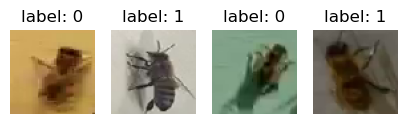

In [15]:
fig = plt.figure(figsize=(5, 3))
Img_idx = [55, 300, 1900, 2000]
for i in range(0, 4):
    Img = Bee_images[Img_idx[i]]
    fig.add_subplot(1, 4, i+1)
    plt.imshow(Img)
    plt.axis('off')
    plt.title("label: " + str(data_final.iloc[Img_idx[i]]["health_categorical"]))

In [16]:
#Converting images to pixel matrices
pixel_matrix = [np.array(image.img_to_array(i)) for i in Bee_images]
np.shape(pixel_matrix)

(3576, 64, 64, 3)

In [17]:
#Converting images into grayscale
gray_matrix = []

for i in range(0, np.shape(pixel_matrix)[0]):
    gry_img = cv2.cvtColor(pixel_matrix[i], cv2.COLOR_BGR2GRAY)
    gray_matrix.append(gry_img)


np.shape(gray_matrix)

(3576, 64, 64)

In [18]:
#normalizing pixel intensity values - all values will be between 0 and 1 now
gray_matrix = [i/255.0 for i in gray_matrix]

In [19]:
#reshaping the 64x64 matrix representing each image, to a 1x4096 
def horizontalStacking(gray_matrix):
    gray_reshaped = []

    for i in range(0, np.shape(gray_matrix)[0]):
        gray_reshaped.append(np.reshape(gray_matrix[i], (-1,)))

    #np.shape(gray_reshaped)
    return gray_reshaped

### Train/Test Split for kNN

In [20]:
gray_reshaped = horizontalStacking(gray_matrix)

In [21]:
n1 = int(np.floor(0.7 * np.shape(gray_reshaped)[0]))
n2 = n1 + int(np.floor(0.2 * np.shape(gray_reshaped)[0]))

In [22]:
final_data = np.array(gray_reshaped)
train_x_knn, val_x_knn, test_x_knn = final_data[:n1,:], final_data[n1:n2,:], final_data[n2:,:]

In [23]:
train_x_knn.shape, val_x_knn.shape, test_x_knn.shape

((2503, 4096), (715, 4096), (358, 4096))

In [24]:
train_y_knn = data_final.loc[:n1-1,:]["health_categorical"]
val_y_knn = data_final.loc[n1:n2-1,:]["health_categorical"]
test_y_knn = data_final.loc[n2:,:]["health_categorical"]

In [25]:
train_y_knn.shape, val_y_knn.shape, test_y_knn.shape

((2503,), (715,), (358,))

### Train/Test Split for CNN 

In [26]:
gray_matrix_arr = np.array(gray_matrix)
gray_matrix_arr.shape

(3576, 64, 64)

In [27]:
train_x_cnn, val_x_cnn, test_x_cnn = gray_matrix_arr[:n1,:], gray_matrix_arr[n1:n2,:], gray_matrix_arr[n2:,:]
train_x_cnn.shape,val_x_cnn.shape, test_x_cnn.shape

((2503, 64, 64), (715, 64, 64), (358, 64, 64))

In [28]:
train_y_cnn = data_final.loc[:n1-1,:]["health_categorical"]
val_y_cnn = data_final.loc[n1:n2-1,:]["health_categorical"]
test_y_cnn = data_final.loc[n2:,:]["health_categorical"]

train_y_cnn.shape, val_y_cnn.shape, test_y_cnn.shape

((2503,), (715,), (358,))

In [29]:
n_trainsamples = n1
n_valsamples = n2-n1
n_testsamples = gray_matrix_arr.shape[0] - n_valsamples - n_trainsamples

In [30]:
train_x_cnn = train_x_cnn.reshape((n_trainsamples, 64, 64, 1))
val_x_cnn = val_x_cnn.reshape((n_valsamples, 64, 64, 1))
test_x_cnn = test_x_cnn.reshape((n_testsamples, 64, 64, 1))
train_x_cnn.shape, val_x_cnn.shape, test_x_cnn.shape

((2503, 64, 64, 1), (715, 64, 64, 1), (358, 64, 64, 1))

### CNN Model

In [31]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
history = model.fit(train_x_cnn, train_y_cnn, epochs=10, 
                    validation_data=(val_x_cnn, val_y_cnn))

Epoch 1/10
79/79 [==============================] - 16s 161ms/step - loss: 0.5934 - accuracy: 0.6252 - val_loss: 0.4675 - val_accuracy: 0.7427
Epoch 2/10
79/79 [==============================] - 12s 154ms/step - loss: 0.4397 - accuracy: 0.7679 - val_loss: 0.3828 - val_accuracy: 0.8042
Epoch 3/10
79/79 [==============================] - 12s 153ms/step - loss: 0.3995 - accuracy: 0.7926 - val_loss: 0.3304 - val_accuracy: 0.8531
Epoch 4/10
79/79 [==============================] - 12s 153ms/step - loss: 0.3549 - accuracy: 0.8270 - val_loss: 0.3335 - val_accuracy: 0.8098
Epoch 5/10
79/79 [==============================] - 12s 151ms/step - loss: 0.2772 - accuracy: 0.8722 - val_loss: 0.2770 - val_accuracy: 0.8587
Epoch 6/10
79/79 [==============================] - 12s 152ms/step - loss: 0.2533 - accuracy: 0.8853 - val_loss: 0.2974 - val_accuracy: 0.8853
Epoch 7/10
79/79 [==============================] - 12s 152ms/step - loss: 0.2166 - accuracy: 0.9045 - val_loss: 0.2519 - val_accuracy: 0.8867

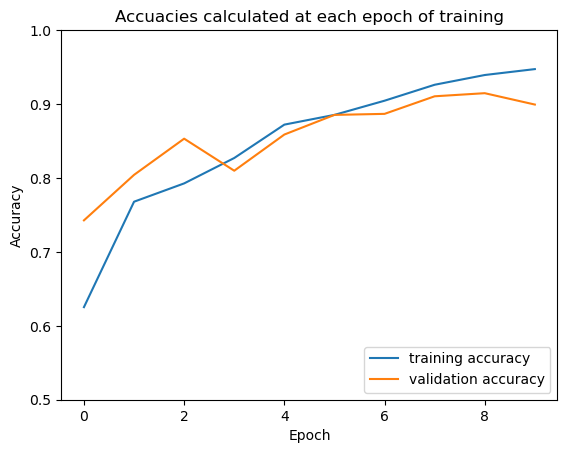

In [53]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuacies calculated at each epoch of training")
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [36]:
test_loss, test_acc = model.evaluate(test_x_cnn,  test_y_cnn, verbose=2)

12/12 - 1s - loss: 0.3058 - accuracy: 0.8911 - 559ms/epoch - 47ms/step


### kNN Model

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [38]:
knn = KNeighborsClassifier(n_neighbors=10)

In [39]:
knn.fit(train_x_knn, train_y_knn)

KNeighborsClassifier(n_neighbors=10)

In [40]:
y_pred = knn.predict(test_x_knn)

In [41]:
accuracy = accuracy_score(test_y_cnn, y_pred)

In [42]:
accuracy

0.7932960893854749

In [43]:
results_training = []
results_validation = []
for k in range(5, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x_knn, train_y_knn)
    
    #Training Accuracy
    y_pred_train = knn.predict(train_x_knn)
    acc_train = accuracy_score(train_y_knn, y_pred_train)
    results_training.append(acc_train)
    
    #Validation Accuracy
    y_pred_val = knn.predict(val_x_knn)
    acc_val = accuracy_score(val_y_knn, y_pred_val)
    results_validation.append(acc_val)

In [44]:
#selcting the best k value
k_final = 5 + np.argmax(results_validation)

In [45]:
k_list = np.arange(5, 21, 1)
k_list

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

Text(0, 0.5, 'Accuracy Score')

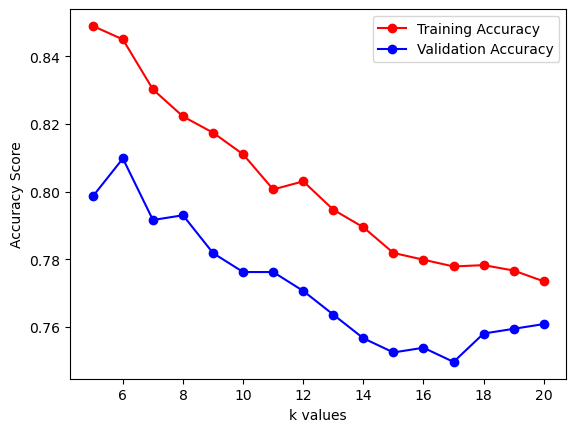

In [54]:
plt.plot(k_list, results_training, 'ro-', k_list, results_validation, 'bo-')
plt.xscale
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel("k values")
plt.ylabel("Accuracy Score")
#plt.title("Training and Validation Accuracies for different values of k")

In [47]:
max(results_validation), np.argmax(results_validation)

(0.8097902097902098, 1)

In [56]:
results_training[1], results_validation[1]

(0.8449860167798642, 0.8097902097902098)

In [49]:
knn_final = KNeighborsClassifier(n_neighbors=k_final)
knn_final.fit(train_x_knn, train_y_knn)
y_pred_test = knn_final.predict(test_x_knn)
accuracy_testing = accuracy_score(test_y_knn, y_pred_test)
accuracy_testing

0.8128491620111732